# 03-123 : Heatmap Model

Create the model definition using the heatmap feature. This model will be later used when training by question.

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import sys
import logging

import pandas as pd
import mlflow

import tensorflow_addons as tfa
import keras as k
from keras import optimizers
import keras_tuner
import keras_tuner as kt

from competition import data_preparation as dp
from competition import feature_engineering as fe
from competition import model_data as md
from competition import source_data as sd
from competition.models.heatmap_covnet import HeatmapCovnetModel

### Configure Logging

In [3]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-31 15:56:18 INFO     Started


## Data Collection

In [4]:
# load the source training set
df_source = sd.read_csv('../data/train.csv.gz',
                        compression='gzip',
                        dtype=sd.source_dtype)

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [5]:
# load the source training labels
df_source_labels = sd.read_csv('../data/train_labels.csv')

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Data Preparation & Cleaning

In [6]:
# prepare the main dataset
df_source = dp.prepare_main_dataset(df_source,
                                    elapsed_time_min_clip=0,
                                    elapsed_time_max_clip=3691298)

# remove sessions with problems
problem_sessions = dp.find_problem_sessions(df_source)
df_source = df_source[~df_source['session_id'].isin(problem_sessions)]

In [7]:
# prepare the label dataset
df_source_labels = dp.prepare_label_dataset(df_source_labels)

# remove sessions with problems
df_source_labels = df_source_labels[~df_source_labels['session_id'].isin(problem_sessions)]

## Feature Engineering

In [8]:
# create the initial features
df_features = fe.create_initial_features(df_source, df_source_labels)

In [9]:
# add the feature to the features dataset
df_features = fe.add_elapsed_time_features(
    features=df_features,
    X=df_source)

In [10]:
# add the total count features to the features dataset
df_features = fe.add_count_total_features(
    features=df_features,
    X=df_source)

In [11]:
# add the unique count features to the features dataset
df_features = fe.add_count_unique_features(
    features=df_features,
    X=df_source)

In [15]:
# add the heatmap features to the features dataset
df_features = fe.add_screen_heatmap_feature(
    features=df_features,
    X=df_source)

  0%|          | 0/11648 [00:00<?, ?it/s]

In [17]:
with pd.option_context('display.max_columns', None):
    display(df_features.head(10))

,session_id,level_group,elapsed_time_sum,elapsed_time_max,elapsed_time_min,elapsed_time_mean,elapsed_time_mode,count_total_event_name,count_total_name,count_total_fqid,count_total_room_fqid,count_total_text_fqid,count_unique_event_name,count_unique_name,count_unique_fqid,count_unique_room_fqid,count_unique_text_fqid,screen_heatmap_feature
0,20090312431273200,0-4,0.001411,0.052535,0.000000,0.023103,0.000000,0.088782,0.088782,0.064620,0.088782,0.054054,0.75,0.000000,0.203390,0.090909,0.225,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,20090312431273200,13-22,0.043740,0.344602,0.226677,0.281804,0.301320,0.394721,0.394721,0.402262,0.394721,0.480127,0.75,0.000000,0.525424,0.545455,0.675,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,20090312431273200,5-12,0.010577,0.135014,0.060002,0.096641,0.060002,0.245951,0.245951,0.276252,0.245951,0.257552,0.75,0.000000,0.355932,0.454545,0.400,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,20090312433251036,0-4,0.001352,0.063074,0.000000,0.026311,0.000000,0.057588,0.057588,0.053312,0.057588,0.050874,1.00,0.333333,0.067797,0.000000,0.075,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,20090312433251036,13-22,0.324157,1.000000,0.318718,0.676403,1.000000,1.000000,1.000000,1.000000,1.000000,0.585056,1.00,1.000000,0.932203,0.909091,0.875,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,20090312433251036,5-12,0.021933,0.221287,0.072301,0.150206,0.072301,0.364727,0.364727,0.400646,0.364727,0.238474,1.00,0.333333,0.457627,0.454545,0.350,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,20090314121766812,0-4,0.002928,0.106324,0.000000,0.047996,0.000000,0.088782,0.088782,0.066236,0.088782,0.044515,1.00,0.333333,0.135593,0.090909,0.175,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
7,20090314121766812,13-22,0.087795,0.577944,0.378781,0.486883,0.378781,0.476305,0.476305,0.444265,0.476305,0.445151,1.00,0.333333,0.661017,0.545455,0.675,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,20090314121766812,5-12,0.027818,0.275332,0.118501,0.195489,0.118501,0.352729,0.352729,0.342488,0.352729,0.248013,1.00,0.333333,0.457627,0.454545,0.375,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,20090314363702160,0-4,0.001627,0.058690,0.000000,0.030143,0.000000,0.065987,0.065987,0.050081,0.065987,0.034976,0.50,0.000000,0.050847,0.090909,0.075,"[[[0.05882353, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


## Data Selection

In [18]:
random_state = 51

In [19]:
# split the dataset into train, validation and test sets
train, val, test = md.select_sessions(
    y=df_source_labels,
    random_state=random_state,
    test_size=0.60,
    train_size=0.75)

Train: 3495
Validation: 1165
Test: 6988


## Model Training

### Create Datasets

In [20]:
# set the feature list
feature_list = ['elapsed_time_sum', 'elapsed_time_max', 'elapsed_time_min', 'elapsed_time_mean', 'elapsed_time_mode']

# create the simple model dataset
features_dataset = md.get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=feature_list,
    train=train,
    val=val,
    test=test,
    include_question=True,
    expand_question=False)

2023-03-31 16:12:32 INFO     -- Creating the train dataset
2023-03-31 16:12:32 INFO     Creating the dataset for all level groups


  0%|          | 0/62910 [00:00<?, ?it/s]

2023-03-31 16:13:19 INFO     -- Creating the val dataset
2023-03-31 16:13:19 INFO     Creating the dataset for all level groups


  0%|          | 0/20970 [00:00<?, ?it/s]

2023-03-31 16:13:36 INFO     -- Creating the test dataset
2023-03-31 16:13:36 INFO     Creating the dataset for all level groups


  0%|          | 0/125784 [00:00<?, ?it/s]

In [21]:
# create the heatmap dataset
heatmap_dataset = md.get_feature_dataset(
    features=df_features,
    y=df_source_labels,
    feature_list=['screen_heatmap_feature'],
    train=train,
    val=val,
    test=test,
    include_question=False,
    expand_question=False)

2023-03-31 16:15:41 INFO     -- Creating the train dataset
2023-03-31 16:15:41 INFO     Creating the dataset for all level groups


  0%|          | 0/62910 [00:00<?, ?it/s]

2023-03-31 16:16:26 INFO     -- Creating the val dataset
2023-03-31 16:16:26 INFO     Creating the dataset for all level groups


  0%|          | 0/20970 [00:00<?, ?it/s]

2023-03-31 16:16:41 INFO     -- Creating the test dataset
2023-03-31 16:16:41 INFO     Creating the dataset for all level groups


  0%|          | 0/125784 [00:00<?, ?it/s]

In [22]:
# convert the labels for multi-label classification
cat_features_dataset = md.labels_to_categorical(features_dataset)

In [38]:
# define the flat heatmap input shape
input_data = heatmap_dataset['train']['X']
heatmap_shape = input_data.shape[1], input_data.shape[2], input_data.shape[3]
print('heatmap_shape:', heatmap_shape)

# get the shape of the question only dataset
input_data = cat_features_dataset['train']['X']
features_dataset_shape = input_data.shape[1]
print('features_dataset_shape:', features_dataset_shape)

# define the output shape
output_data = cat_features_dataset['train']['y']
output_shape = output_data.shape[1]
print('output_shape', output_shape)

heatmap_shape: (23, 10, 10)
features_dataset_shape: 23
output_shape 2


### Training

In [39]:
# create the experiment
mlflow.set_experiment("heatmap_trial_01")

<Experiment: artifact_location='file:///workspaces/dsm150-2022-oct/cw02/phase_03/mlruns/565982337616333696', creation_time=1680281755961, experiment_id='565982337616333696', last_update_time=1680281755961, lifecycle_stage='active', name='heatmap_trial_01', tags={}>

In [40]:
# define the tuner parameters
def define_tune_parameters(hp):
    hp.Int('covnet_block_count', min_value=1, max_value=3, step=1)
    hp.Choice('covnet_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Int('covnet_cov_count', min_value=1, max_value=3, step=1)
    hp.Int('covnet_channels', min_value=32, max_value=64, step=16)
    hp.Choice('covnet_kernel_size', values=['(3, 3)'])
    hp.Choice('covnet_pool_size', values=['(2, 2)'])

    hp.Int('dense_layer_count', min_value=1, max_value=20, step=1)
    hp.Int('dense_units', min_value=640, max_value=1700, step=32)
    hp.Choice('dense_activation', values=['relu', 'tanh', 'LeakyReLU'])
    hp.Float('dense_l1_regularization', min_value=0.0, max_value=0.0005, step=0.00001)
    hp.Float('dense_l2_regularization', min_value=0.0, max_value=0.001, step=0.0001)
    hp.Float('dense_dropout', min_value=0.005, max_value=0.1, step=0.005)
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])

In [41]:
# create the model object
heatmap_model = HeatmapCovnetModel(
    input_shape=features_dataset_shape,
    heatmap_shape=heatmap_shape,
    output_shape=output_shape,
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(name='f1_score', num_classes=2, threshold=0.5, average='macro')])

In [42]:
mlflow.end_run()

Trial 3 Complete [00h 00m 22s]
val_f1_score: 0.6402279734611511

Best val_f1_score So Far: 0.6402279734611511
Total elapsed time: 00h 02m 04s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
1                 |1                 |covnet_block_count
relu              |LeakyReLU         |covnet_activation
2                 |2                 |covnet_cov_count
32                |48                |covnet_channels
(3, 3)            |(3, 3)            |covnet_kernel_size
(2, 2)            |(2, 2)            |covnet_pool_size
19                |3                 |dense_layer_count
1280              |1440              |dense_units
LeakyReLU         |tanh              |dense_activation
4e-05             |0.00027           |dense_l1_regularization
0                 |0.0007            |dense_l2_regularization
0.095             |0.07              |dense_dropout
0.01              |0.01              |learning_rate

2023-03-31 17:31:15 INFO     Creating a heatmap CNN mo

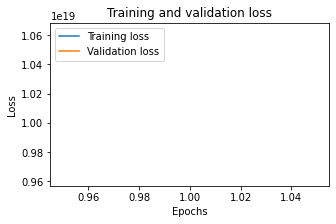

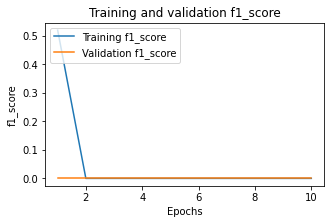

2622/2622 [==============================] - 3s 1ms/step


#### Threshold: 0.5
```
              precision    recall  f1-score   support

         0.0       0.30      1.00      0.46     37388
         1.0       1.00      0.00      0.00     88396

    accuracy                           0.30    125784
   macro avg       0.65      0.50      0.23    125784
weighted avg       0.79      0.30      0.14    125784

```

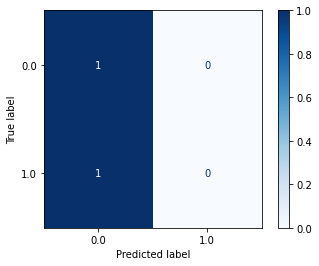

In [43]:
# search for the best model
heatmap_model.tune_model(
    define_tune_parameters=define_tune_parameters,
    heatmap_dataset=heatmap_dataset,
    feature_dataset=cat_features_dataset,
    max_trials=10,
    train_epochs=10,
    train_batch_size=1000,
    train_optimizer=optimizers.Adam,
    tuner_type=kt.tuners.RandomSearch,
    tune_objective='val_f1_score',
    tune_direction='max',
    train_class_weight=None)